# Poetry generator
In this sheet, we will generate synthetic poems (including the title and the author). The user will pass the word or words with which he wants the title of the poem to begin. The algorithm will return the full title of the poem, the author, and the synthetically generated content. For this, we are going to use Long-short Term Memory (LSTM) networks. This type of recurrent neural networks (RNNs) are very used in NLPs tasks. The model is trained with a *poetry dataset* cooked by us, with scrapped textual data obtained from a Spanish poetry blog. 

This notebook is inspired in: https://github.com/trekhleb/machine-learning-experiments/blob/master/assets/recipes_generation.en.md. They proposed the algorithm to generate automatically new recipes.

## 1. Import libraries and load the data


First, we import the libraries that we are going to use. We use Tensorflow (2.0) for the model. 

In [68]:
# Libraries

# Packages for training the model and working with the dataset.
import os
import json

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

Then, we load the data from the Google Drive. The data is in .csv format and it is composed by the poems of the Spanish blog. It has three columns: title, author and content. And, there are 5133 different poems of the Spanish literature with very important and famous poets such as Neruda or Góngora. 

In [69]:
# Mount Drive files
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
sst_home = 'drive/My Drive/Colab Notebooks/poetry_generator/data/'

#read_dataset
poems_df = pd.read_csv(sst_home + 'poems.csv')

#shape of the dataset
print(poems_df.shape)

(5133, 3)


We show the five first elements of the poetry dataframe.

In [71]:
poems_df.head()

,author,content,title
0,Leopoldo Lugones,\n\r\nEn el parque confuso\r\nQue con lánguida...,LA MUERTE DE LA LUNA
1,Marilina Rébora,"\n\r\nPorque si tú no velas, vendré como ladró...",PORQUE SI TÚ NO VELAS
2,Antonio Colinas,"\n\r\nPequeña de mis sueños, por tu piel las p...",POEMA DE LA BELLEZA CAUTIVA QUE PERDÍ
3,José María Hinojosa,\n\r\nLos dedos de la nieve\r\nrepiquetearon\r...,SENCILLEZ
4,Rubén Izaguirre Fiallos,"Naciste en Armenia,\r\npero te fuiste a vivir ...",Breve Carta a Consuelo Suncín


## Filtering poems

We have to remove the poems that we are not useful for this task. First, we remove the elements that contain missing values. Then, we create an additional column named "string" which is the concatenation of the title, the author and the content of the poems. Finally, we get rid of all the poems longer than an specific length. In this case we set it to 1000 characters.

In [72]:
#Remove any row with one missing value (two in total)
poems_df = poems_df.dropna()

In [73]:
def poem_to_string(poem):
  return f'\n{poem["title"]}\n{poem["author"]}\n{poem["content"]}'

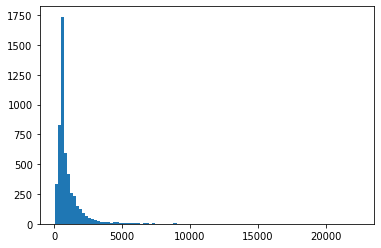

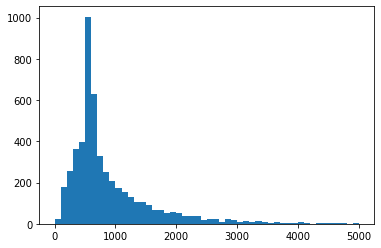

There are  3632 poems after filtering by length (considering poems with lenght less than 1000).


In [74]:
#Filtering out large poems
poems_df['string'] = poems_df.apply(lambda row: f'\n{row["title"]}\n\n{row["author"]}\n\n{row["content"]}', axis=1)
poems_df['length'] = poems_df.string.map(len)

#Histogram for seeing length poem distribution
plt.hist(poems_df['length'].values, bins=100)
plt.show()
plt.hist(poems_df['length'].values, range=(0,5000), bins=50)
plt.show()

#We consider 1000 as the maximum length to filter
MAX_POEM_LENGTH=1000
poems_filtered = poems_df[poems_df.length<MAX_POEM_LENGTH]

print('There are ', len(poems_filtered), 'poems after filtering by length (considering poems with lenght less than 1000).')

## Creating Vocabulary

We have to create the vocabulary. In this experiment we're going to use a character-level language 🔡 model based on multi-layer LSTM (Long Short-Term Memory) network (as opposed to word-level language model). It means that instead of creating unique indices for words we will create unique indices for characters. By doing that we let the network predict the next character instead of the next word in a sequence. So we will have many characters such as 'a', '\n', 'A', 'á'...

In [75]:
poems_string=poems_filtered.string

First, we get the token for every character. Since neural network uses numbers instead of strings, we convert each character into a number.

In [76]:
STOP_SIGN = '␣'

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters='',
    lower=False,
    split=''
)

# Stop word is not a part of recipes, but tokenizer must know about it as well.
tokenizer.fit_on_texts([STOP_SIGN])

tokenizer.fit_on_texts(poems_string)

tokenizer.get_config()

{'char_level': True,
 'document_count': 3633,
 'filters': '',
 'index_docs': '{"1": 3632, "119": 1, "16": 3607, "11": 3620, "56": 849, "25": 3286, "46": 1393, "24": 3310, "64": 218, "40": 1846, "45": 1608, "48": 1232, "27": 2987, "7": 3629, "43": 1519, "4": 3630, "9": 3632, "47": 1327, "29": 2872, "44": 1566, "35": 2249, "6": 3631, "8": 3628, "38": 2070, "20": 3462, "2": 3631, "13": 3623, "17": 3564, "30": 2749, "26": 3046, "34": 2478, "19": 3488, "12": 3628, "42": 1803, "58": 949, "87": 50, "10": 3631, "3": 3632, "52": 1035, "33": 2436, "5": 3628, "21": 3460, "39": 1866, "32": 2569, "18": 3151, "36": 2098, "15": 3611, "49": 1052, "41": 1928, "53": 1078, "23": 3335, "14": 3623, "22": 3454, "31": 2542, "57": 1069, "75": 120, "28": 2977, "73": 148, "37": 1977, "84": 35, "60": 914, "62": 791, "55": 1155, "67": 188, "63": 801, "61": 837, "66": 314, "76": 46, "65": 316, "93": 35, "54": 722, "59": 664, "77": 82, "50": 850, "51": 786, "68": 286, "82": 48, "97": 23, "89": 34, "88": 35, "71": 1

The vocabulary size is 129, that means that we have codified 129 different characters that appeared in the corpus. Notice that there may have many of them because of the accents or the capital letters.

In [77]:
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1

print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

VOCABULARY_SIZE:  129


Given a word we can get its numerical representation and the reverse with the tokenizer.



In [78]:
print(tokenizer.index_word[5])
print(tokenizer.index_word[10])

s
i


In [79]:
print(tokenizer.word_index['z'])
print(tokenizer.word_index['i'])

28
10


Finally, we are able to create a sequence from a given text. This a way to convert the text into numbers.

In [80]:
tokenizer.texts_to_sequences(['poesía eres tú'])

[[17, 4, 2, 5, 27, 3, 1, 2, 6, 2, 5, 1, 13, 46]]

## Vectorizing the dataset 
Once, we have the vocabulary defined we convert the set of poems into sequences. Notice that we have the opposite operation, given a sequence we can recover the text. Roughly, the idea is to convert the text into vector do whatever (some operations 🧮) with the numbers and at the end recover the latent text.

In [81]:
dataset_vectorized = tokenizer.texts_to_sequences(poems_string)

print('Vectorized dataset size', len(dataset_vectorized))

Vectorized dataset size 3632


In [82]:
#Function for getting the inverse (seq2str)
def poem_sequence_to_string(poem_sequence):
    poem_stringified = tokenizer.sequences_to_texts([poem_sequence])[0]
    print(poem_stringified)

poem_sequence_to_string(dataset_vectorized[0])


 P O R Q U E   S I   T Ú   N O   V E L A S 
 
 M a r i l i n a   R é b o r a 
 
 
 
 
 
 
 y   l o   q u e   h a s   r e c i b i d o   y   e s c u c h a d o ,   m e m o r a . 
 
 
 
 
 s i   e s   q u e   n o   t e   a r r e p i e n t e s   y   d e   o t r o   m o d o   o b r a s . 
 
 
 
 
 
 
 
 V e n d r é   c o m o   l a d r ó n ,   d e   i m p r o v i s o   o   a   o s c u r a s .


Not all poems have the same length which is a problem for the neural network. The neural network expects a fixed shape for the input. To overcome this issue, we add padding to the shorter poems so every the poem have the maximum length (1000). We add the padding with the STOPWORD.

In [83]:
for poem_index, poem in enumerate(dataset_vectorized[:10]):
    print('Poem #{} length: {}'.format(poem_index + 1, len(poem)))

Poem #1 length: 747
Poem #2 length: 676
Poem #3 length: 287
Poem #4 length: 424
Poem #5 length: 358
Poem #6 length: 202
Poem #7 length: 575
Poem #8 length: 579
Poem #9 length: 920
Poem #10 length: 598


In [84]:
dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    # We use -1 here and +1 in the next step to make sure
    # that all poems will have at least 1 stops sign at the end,
    # since each sequence will be shifted and truncated afterwards
    # (to generate X and Y sequences).
    maxlen=MAX_POEM_LENGTH-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_POEM_LENGTH+1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

for poem_index, poem in enumerate(dataset_vectorized_padded[:10]):
    print('Poem #{} length: {}'.format(poem_index + 1, len(poem)))

Poem #1 length: 1001
Poem #2 length: 1001
Poem #3 length: 1001
Poem #4 length: 1001
Poem #5 length: 1001
Poem #6 length: 1001
Poem #7 length: 1001
Poem #8 length: 1001
Poem #9 length: 1001
Poem #10 length: 1001


Now all the poems have the same length and we show one example.

In [85]:
poem_sequence_to_string(dataset_vectorized_padded[1290])


 D E P A R T 
 
 V i c e n t e   H u i d o b r o 
 
 
 
 
                   S o b r e   l a s   o l a s   c ó n c a v a s 
 
 
                                                                                                                   b r o t a b a n   l a s   c a n c i o n e s 
 
 
                   S e   b a t í a n   a l   v i e n t o 
 
 
 F l o r e c e n   a l   v a c í o 
 
 
                                                                                                       s i n   p o d e r   r e c o g e r l a s 
 
                   E l   ú l t i m o   v e r s o   n u n c a   s e r á   c a n t a d o 
 
 
 U n a   m u j e r   d e c í a   a d i ó s   d e s d e   l a   p l a y a 
 
       T O D A S   L A S   G O L O N D R I N A S   S E   R O M P I E R O N   L A S   A L A S ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ 

## Create TensorFlow dataset

Once we have the text converted into vectors (numpy arrays actually) we have to adapt them into the tensorflow format. 

In [86]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)

print(dataset)

<TensorSliceDataset shapes: (1001,), types: tf.int32>


We have to split each element into input and target. Given the input the model will try to predict the target (i.e. the continuation of the input). Several splits could be done. For example, if we have the sentence "Poesía" and the sequence_length is 5, given "Poesí" the target sequence will be "oesía".

In [87]:
def split_input_target(poem):
    input_text = poem[:-1]
    target_text = poem[1:]
    
    return input_text, target_text

dataset_targeted = dataset.map(split_input_target)

print(dataset_targeted)

<MapDataset shapes: ((1000,), (1000,)), types: (tf.int32, tf.int32)>


Now the datasit is a tuple of two elements (input, target). Let's print an example:

In [88]:
for input_example, target_example in dataset_targeted.take(5):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    
    input_stringified = tokenizer.sequences_to_texts([input_example.numpy()[:5]])[0]
    target_stringified = tokenizer.sequences_to_texts([target_example.numpy()[:5]])[0]
    
    print('Input:  ', repr(''.join(input_stringified)))
    print('Target: ', repr(''.join(target_stringified)))

Input sequence size: 1000
Target sequence size: 1000

Input:   '\n P O R Q'
Target:  'P O R Q U'
Input sequence size: 1000
Target sequence size: 1000

Input:   '\n P O E M'
Target:  'P O E M A'
Input sequence size: 1000
Target sequence size: 1000

Input:   '\n S E N C'
Target:  'S E N C I'
Input sequence size: 1000
Target sequence size: 1000

Input:   '\n B r e v'
Target:  'B r e v e'
Input sequence size: 1000
Target sequence size: 1000

Input:   '\n P A S A'
Target:  'P A S A D'


Each index of these vectors is processed as one time step by RNN. For the input at time step 0 , the model receives the index for '\n' and tries to predict the index for the next character. At the next time-step, it does the same thing, but the RNN considers the previous step context in addition to the current input character.

## Split up the dataset into batches

It is difficult to train the model using the whole dataset in each optimization step because we probably get out of memory 😟. Furthermore, training in batches speeds up the training process 😃. That is to only pass a limited number of elements, in this case 64, in each training step 🤔.

In [89]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
SHUFFLE_BUFFER_SIZE = 1000

dataset_train = dataset_targeted.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).repeat()


print(dataset_train)

<RepeatDataset shapes: ((64, 1000), (64, 1000)), types: (tf.int32, tf.int32)>


Finally, what we have in the training process are batches of size 64. Each element of the batch is the sequence that codifies the corresponding poem. Remember that they are split into input and target. Notice that the target is the shift vector of the input_text.

In [90]:
for input_text, target_text in dataset_train.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[  9  39   2 ... 119 119 119]
 [  9  38  12 ... 119 119 119]
 [  9  31   1 ... 119 119 119]
 ...
 [  9  38   3 ... 119 119 119]
 [  9  45  25 ... 119 119 119]
 [  9  31   1 ... 119 119 119]], shape=(64, 1000), dtype=int32)

1st batch: target_text: tf.Tensor(
[[ 39   2   5 ... 119 119 119]
 [ 38  12   3 ... 119 119 119]
 [ 31   1  31 ... 119 119 119]
 ...
 [ 38   3   6 ... 119 119 119]
 [ 45  25   3 ... 119 119 119]
 [ 31   1  39 ... 119 119 119]], shape=(64, 1000), dtype=int32)


## Build the model

Now, we proceed to build the model for generating poetry. This model is build with [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential). It consist of three stacked layers: 


- [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) - the input layer (a trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions),
- [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) - a type of RNN with size `units=rnn_units` (you can also use a [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) layer here),
- [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) - the output layer, with `VOCABULARY_SIZE` outputs.


### LSTM Model

In [91]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model

model = build_model(
  vocab_size=VOCABULARY_SIZE,
  embedding_dim=256,
  rnn_units=1024,
  batch_size=BATCH_SIZE
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (64, None, 256)           33024     
_________________________________________________________________
lstm_4 (LSTM)                (64, None, 1024)          5246976   
_________________________________________________________________
dense_4 (Dense)              (64, None, 129)           132225    
Total params: 5,412,225
Trainable params: 5,412,225
Non-trainable params: 0
_________________________________________________________________


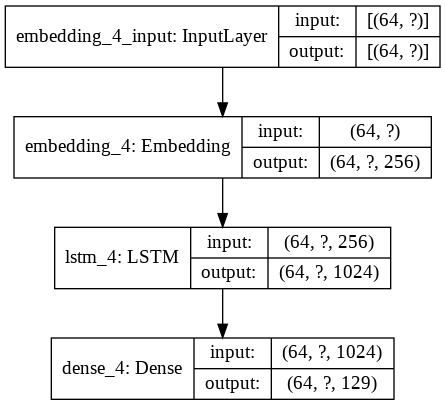

In [92]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    to_file='model.png'
)

Look that a batch of 64 elements is introduced in the model. Then it is feed to a embedding layer which maps the numbers of the sequence to vectors in a 256-dimensional space. Then it is applied a LSTM layer to the resulting vectors and finally a Dense layer will give the probability for the next character to appear. Notice that it has a dimension of 129 (the vocabulary_size), so it gives the probability to each character.

## Training the model

Let's assemble the model.

ℹ️ You may check [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) notebook from TensorFlow documentation for more details on model components.

In [ ]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
    
    return entropy

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

# Configuring callbacks

## Early stopping callback

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

## Model checkpoints stopping callback

In [ ]:
# Create a checkpoints directory.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

# Execute the training

We defined global parameters. The `EPOCHS` are the number of iterations that the model will do and `STEPS_PER_EPOCH` the number of optimization step that are done in each epoch. Tipically, in each epoch the model sees the whole dataset, in this case, we will do less steps to speed up the process.

In [ ]:
# EPOCHS = 30
# INITIAL_EPOCH = 0
# STEPS_PER_EPOCH = 10

# EPOCHS = 500
# INITIAL_EPOCH = 1
# STEPS_PER_EPOCH = 1500

EPOCHS = 90
INITIAL_EPOCH = 0
STEPS_PER_EPOCH = 75

print('EPOCHS:          ', EPOCHS)
print('INITIAL_EPOCH:   ', INITIAL_EPOCH)
print('STEPS_PER_EPOCH: ', STEPS_PER_EPOCH)

EPOCHS:           90
INITIAL_EPOCH:    0
STEPS_PER_EPOCH:  75


In [ ]:
history = model.fit(
    x=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback
    ]
)

Epoch 1/90
75/75 [==============================] - 116s 2s/step - loss: 2.0409
Epoch 2/90
75/75 [==============================] - 117s 2s/step - loss: 1.3970
Epoch 3/90
75/75 [==============================] - 117s 2s/step - loss: 1.2413
Epoch 4/90
75/75 [==============================] - 117s 2s/step - loss: 1.1849
Epoch 5/90
75/75 [==============================] - 117s 2s/step - loss: 1.1270
Epoch 6/90
75/75 [==============================] - 118s 2s/step - loss: 1.0798
Epoch 7/90
75/75 [==============================] - 118s 2s/step - loss: 1.0470
Epoch 8/90
75/75 [==============================] - 118s 2s/step - loss: 1.0170
Epoch 9/90
75/75 [==============================] - 117s 2s/step - loss: 0.9778
Epoch 10/90
75/75 [==============================] - 118s 2s/step - loss: 0.9538
Epoch 11/90
75/75 [==============================] - 118s 2s/step - loss: 0.9245
Epoch 12/90
75/75 [==============================] - 117s 2s/step - loss: 0.8931
Epoch 13/90
75/75 [==================

In [ ]:
# Saving the trained model to file (to be able to re-use it later).

path_network = 'drive/My Drive/Colab Notebooks/poetry_generator/saved_network/'
model_name = 'poem_generation_rnn_raw.h5'
model.save(path_network + model_name, save_format='h5')

## Visualizing training progress

We can see the loss how evolves through the training. In fact, the model converges.

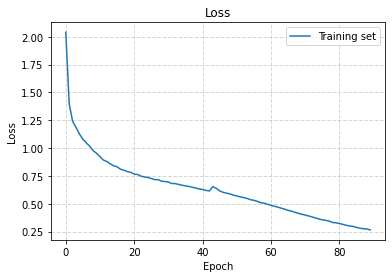

In [97]:
def render_training_history(training_history):
    #loss = training_history.history['loss']
    loss = training_history

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    
    plt.savefig('./training_history.png')
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

#np.save(path_network + "history_1.npy", history.history['loss'])
history = np.load(path_network + "history_1.npy")
render_training_history(history)

##Generating text

Once the model is trained we are ready to have some fun 🤪. Since the model was saved. We can define again the model and load the weights. 
For each input character the example_batch_predictions array contains a vector of probabilities of what the next character might be. If probability at position 15 in that vector is, lets say, 0.3 and the probability at position 25 is 0.8 it means that we should better pick the character with the index 25 as next following character.

Since we want our network to generate different poems (even for the same input), we can't just pick the maximum probability value. In this case we will end up with the same poem being predicted by the network over and over again. What we will do instead is drawing samples from predictions (like the one printed above) by using tf.random.categorical() function. It will bring some fuzziness to the network. For example, let's say we have character P as an input, then, by sampling from categorical distribution, our network may predict not only the word Poem, but also words Princesa👸, and Pájaro🐦 etc.

## Restore the model

To keep this prediction step simple, we will restore the saved model and rebuild it with a batch size of 1. Because of the way the RNN state is passed from time-step to time-step, the model only accepts a fixed batch size once built. To run the model with a different batch_size, we need to rebuild the model and restore the weights from the checkpoint.

In [98]:
tf.train.latest_checkpoint(checkpoint_dir)
simplified_batch_size = 1

rnn_units = 1024
embedding_dim = 256


model_simplified = build_model(VOCABULARY_SIZE, embedding_dim, rnn_units, simplified_batch_size)
model_simplified.load_weights(path_network + model_name)
model_simplified.build(tf.TensorShape([simplified_batch_size, None]))
#model.save(path_network +'trained_model.h5', save_format='h5')
#model.save_weights(path_network +'weight_model.h5', save_format='h5')
model_simplified.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (1, None, 256)            33024     
_________________________________________________________________
lstm_5 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_5 (Dense)              (1, None, 129)            132225    
Total params: 5,412,225
Trainable params: 5,412,225
Non-trainable params: 0
_________________________________________________________________


The temperature parameter here defines how fuzzy or how unexpected the generated recipe is going to be. Low temperatures results in more predictable text. Higher temperatures result in more surprising text. You need to experiment to find the best setting. We will do some experimentation with different temperatures below.

In [99]:
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)
    
    #padded_start_string = STOP_WORD_TITLE + start_string COMENTADO POR MIKE
    padded_start_string = start_string

    # Converting our start string to numbers (vectorizing).
    input_indices = np.array(tokenizer.texts_to_sequences([padded_start_string]))

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1, 0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        
        next_character = tokenizer.sequences_to_texts(input_indices.numpy())[0]

        text_generated.append(next_character)

    return (padded_start_string + ''.join(text_generated))

Finally, we reach to the main result of this notebook.  We iterate through different start words and different temperatures obtaining different poems by the network. This is wonderful. See how the generated poems does not match with any other poem in the corpus. For a moment I almost feel that the computer has a soul 🤗. 

Look to this verses: 
`El ciego del dolor enamora:
El hombre es nadie.
`

I can feel it!

In [ ]:
def generate_combinations(model):
    poem_length = 1000
    try_letters = ['A', 'Corazón', 'Alma', 'El', 'La', 'Lamento', 'Vuelo', 'Otoño']
    try_temperature = [1.0, 0.8, 0.4, 0.2]

    for letter in try_letters:
        for temperature in try_temperature:
            generated_text = generate_text(
                model,
                start_string=letter,
                num_generate = poem_length,
                temperature=temperature
            )
            print(f'Attempt: "{letter}" + {temperature}')
            print('-----------------------------------')
            print(generated_text.replace(STOP_SIGN, ""))
            print('\n\n')

In [ ]:
generate_combinations(model_simplified)

Attempt: "A" + 1.0
-----------------------------------
AÑQUÍBERAS DE ORO

Dulice Albraíz



Daque a muerte falta, aunque interosal
Tierno brillo (Aracia Cós]
Decharino en Soledad?

Sigue turbumentos la ventana
A quien se estiran y verás,
mas que fortunas o mejores,
amanquear partín lirioso
Del esplendo y doraido
Instrumento y hoja de años.
Semillera fábula inconsciente
Córjato de amor y el orojeo
Que las noche me escapa.

No le aterro por siempre en rosa;
Cuando de la luz que descanse
Ya no fue ayer, y si no rememo,
Dulce costa de la Unidad.

Con dos tiempos el ser dichoso
Fue ese pequeño sombre y aleva
de la bolsa más enferma.

...

(En mi mismo honor de alegría
la suerte se posoral,
Que juro de las Burguas mallara;
De aquel mortal templo risa"
Ovitorio vienes
De luceros o luminosos
De dios calor con lágrimas,

Y que la primil ausencia esa
Columna arriba, en una noche,
Que nadie es extranjero naranja,
Que más poder él cautial madre.



Attempt: "A" + 0.8
------------------------------